In [1]:
import numpy as np
import kimimaro as km
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import seaborn as sns
import imageio.v3 as iio
import h5py
from cloudvolume import CloudVolume 
import re
from tqdm import tqdm
import pandas as pd

from neuprint import skeleton as npskel
import networkx as nx

# mini tutorial video

https://www.youtube.com/watch?v=tyQGQtw2WIE

# VAST .raw SEG to cloudvolume precomputed

##  stack .raw to hdf5 numpy array dset

In [3]:
rawpath = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_consolidate_reconstructed/image_stacks')
h5path = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/h5')
cell_folder = 'OUTPUT_in-sub-vol'

# Define file paths
fullpath = rawpath / cell_folder
raw_files = sorted(Path(fullpath).glob("*.raw"))  # Ensure files are sorted correctly
output_file = h5path / f'{cell_folder}.h5'
dataset_name = "volume"

# Dimensions and other parameters
mip_level = 3
VAST_res = [30,16,16]  #(nm/px) z,y,x 
vox_res = (120,128,128)#(120,128,128) #(nm/px) z,y,x  # (nm/px) z,y,x 
x_box = [10001,23000]
y_box = [3101,18500]
z_box = [0,3535]
data_type = np.uint8
width = int(raw_files[0].name.split('_')[-2].split('x')[0])
height = int(raw_files[0].name.split('_')[-2].split('x')[1])
z_slices = len(raw_files)


# Create the HDF5 file
with h5py.File(output_file, "w") as hdf:
    # Create an empty dataset with the full dimensions
    dset = hdf.create_dataset(dataset_name, 
                              shape=(z_slices, height, width), 
                              dtype="uint8")
    
    # Write metadata
    dset.attrs["description"] = "3D volume data"
    dset.attrs["width"] = width
    dset.attrs["height"] = height
    dset.attrs["depth"] = z_slices
    dset.attrs["res"] = vox_res
    dset.attrs["offset"] = (np.min(z_box)*VAST_res[0]/vox_res[0], 
                            np.min(y_box)*VAST_res[1]/vox_res[1], 
                            np.min(x_box)*VAST_res[2]/vox_res[2])
    dset.attrs["order"] = ('z', 'y', 'x')
    dset.attrs["mip"] = mip_level

    # Process and write slices one at a time
    with tqdm(total=len(raw_files)) as pbar:
        for z, file_path in enumerate(raw_files):
            pbar.update(1)
            with open(file_path, "rb") as f:
                slice_data = np.fromfile(f, dtype="uint8").reshape((height, width))
                dset[z, :, :] = slice_data  # Write directly to the HDF5 dataset

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 884/884 [00:04<00:00, 201.72it/s]


## read h5 file 

In [4]:
h5path = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/h5')

In [5]:
# cell_folder = 'sg2_387415866_crude_mip3'

In [6]:
# Define the file name and dataset name
hdf_file = h5path / f'{cell_folder}.h5'
# Open the HDF5 file in read mode
with h5py.File(hdf_file, "r") as hdf:
    # Access the dataset
    dset = hdf["volume"]
    print(dict(dset.attrs))
    volume = hdf["volume"][:]
    res = dset.attrs['res']
    order = dset.attrs['order']
    offset = dset.attrs['offset']


{'depth': 884, 'description': '3D volume data', 'height': 1925, 'mip': 3, 'offset': array([   0.   ,  387.625, 1250.125]), 'order': array(['z', 'y', 'x'], dtype=object), 'res': array([120, 128, 128]), 'width': 1625}


In [44]:
print(f'{volume.shape} in {order}')

(880, 1456, 832) in ['z' 'y' 'x']


In [7]:
collapsed = volume.sum(axis=0)

In [172]:
np.unique(volume)

array([0, 1, 2, 3, 4], dtype=uint8)

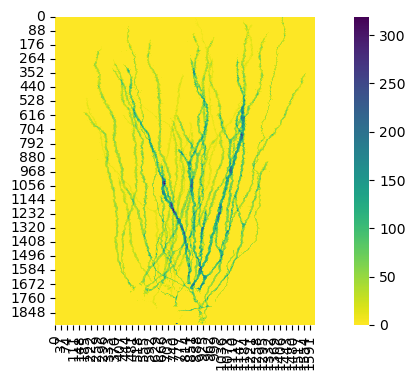

In [8]:
hfig,ax = plt.subplots(1,figsize=(10,4))
# sns.heatmap(volume[489,:,:],cmap = 'viridis_r',ax=ax)
sns.heatmap(collapsed,cmap = 'viridis_r',ax=ax)
ax.set_aspect('equal')

## create precomputed using CloudVolume

In [38]:
help(CloudVolume.from_numpy)

Help on method from_numpy in module cloudvolume.cloudvolume:

from_numpy(arr, vol_path='file:///tmp/image/5pwujk', resolution=(4, 4, 40), voxel_offset=(0, 0, 0), chunk_size=(128, 128, 64), layer_type=None, max_mip=0, encoding='raw', compress=None, progress=False) method of builtins.type instance
    Create a new dataset from a numpy array.
    
    max_mip: (int) the maximum mip level id in the info file. 
    Note that currently the numpy array can only sit in mip 0,
    the max_mip was only created in info file.
    the numpy array itself was not downsampled.



### note can do with igneous

(ell-kimimaro) kperks@Kristas-Mac-mini VAST_to_ng % igneous image --help     
Usage: igneous image [OPTIONS] COMMAND [ARGS]...

  Manipulate image volumes. (subgroup)

  Images are the base datastructure in Neuroglancer. This subgroup offers
  methods for downsampling, transfers, reencoding, rechunking, sharding, and
  contrast correction.

Options:
  --help  Show this message and exit.

Commands:
  ccl         Perform connected components labeling on the image.
  contrast    Perform contrast correction on the image.
  create      Create a Precomputed volume from another data source.
  downsample  Create an image pyramid for grayscale or labeled images.
  reorder     Re-arrange z-slices.
  rm          Delete the image layer of a dataset.
  roi         Computes bounding box of non-empty image regions.
  voxels      Compute voxel counts per label.
  xfer        Copy, re-encode, or shard an image layer.
(ell-kimimaro) kperks@Kristas-Mac-mini VAST_to_ng % igneous image create --help
Usage: igneous image create [OPTIONS] SRC DEST

  Create a Precomputed volume from another data source.

  Supports: .npy files, .h5/.hdf5 files, and .ckl files

  Hopefully will support others such as TIFF in the future.

Options:
  --resolution TUPLE3        Resolution of the volume in nanometers along x,y,
                             and z dimensions.  [default: 1, 1, 1]
  --offset TUPLE3            Voxel offset in x,y, and z.  [default: 0, 0, 0]
  --seg                      Sets layer type to segmentation (default image).
  --encoding ENCODING        Which image encoding to use. Options: [all] raw,
                             png; [images] jpeg, jpegxl (jxl); [segmentations]
                             compressed_segmentation (cseg), compresso (cpso),
                             crackle (ckl); [floats] fpzip, kempressed, zfpc
                             [default: raw]
  --encoding-level TEXT      For some encodings (png level, jpeg & jpeg xl
                             quality, fpzip precision) a simple scalar value
                             can adjust the compression efficiency.
  --encoding-effort INTEGER  (JPEG XL) Set effort (1-10) used by JPEG XL to
                             hit the quality target.  [default: 5]
  --compress COMPRESS        Set the image compression scheme. Options:
                             'none', 'gzip', 'br'  [default: br]
  --chunk-size TUPLE3        Chunk size of new layers. e.g. 128,128,64
                             [default: 128, 128, 64]
  --h5-dataset TEXT          Which h5 dataset to acccess (hdf5 imports only).
                             [default: main]
  --help                     Show this message and exit.


In [9]:
# Define the output directory for the precomputed volume
output_dir = h5path.parent / f'precomputed/{cell_folder}'

axis_order = [np.where(order == axis)[0][0] for axis in ['x','y','z']]

# Create a CloudVolume object from the NumPy array
vol = CloudVolume.from_numpy(
    np.transpose(volume, axes=axis_order),#volume.T,
    vol_path=str(output_dir),
    voxel_offset=[offset[i] for i in axis_order],#(256,928, 64),
    resolution=[res[i] for i in axis_order],#(256, 256, 240),  # Example: 4x4x40 nm voxel size
    layer_type='segmentation',     # For image data; use 'segmentation' for label data
    max_mip=0
)

# # Save the volume
# vol.commit()  # Writes data to the specified directory
# print("Volume saved to:", output_dir)

In [451]:
volume.T.shape

(1232, 4064, 1448)

# import raw EM from VAST into numpy array

from image_stacks folder, run `python stack_to_volume.py`

In [908]:
rawpath = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_consolidate_reconstructed/image_stacks')

cell_folder = 'EM_mip2'

In [909]:
fullpath = rawpath / cell_folder
raw_files = sorted(list(fullpath.glob('*.raw')))

In [910]:
raw_files[0]

PosixPath('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_consolidate_reconstructed/image_stacks/EM_mip2/ELL_export_s0000_8064x8192_8bpp.raw')

In [911]:
len(raw_files)

992

In [380]:
# Define parameters
width = int(raw_files[0].name.split('_')[-2].split('x')[0])
height = int(raw_files[0].name.split('_')[-2].split('x')[1])
data_type = np.uint8

# Read all slices and stack into a 3D array
slices = []
for file_name in raw_files:
    file_path = rawpath / file_name
    with open(file_path, "rb") as f:
        slice_data = np.fromfile(f, dtype=data_type).reshape((height, width))
        
        slices.append(slice_data)

# Stack slices along the z-axis
volume = np.stack(slices, axis=0)

print(f'{volume.shape} in z,y,x')



(884, 4096, 4032) in z,y,x


In [381]:
volume.shape

(884, 4096, 4032)

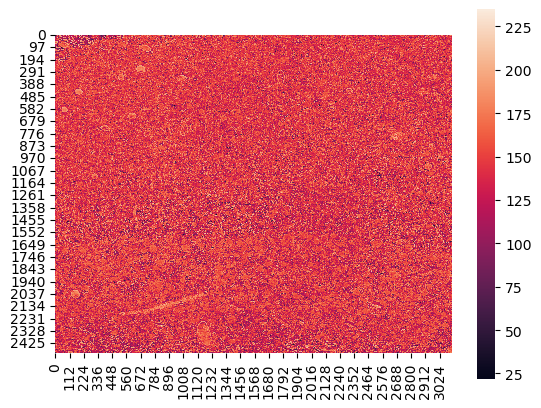

In [264]:
h = sns.heatmap(volume[0,:,:])
ax = plt.gca()
ax.set_aspect('equal')

## export volume to h5

part of `ptyhon stack_to_volume`

In [382]:
h5path = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/h5')

In [383]:
x_box = [0]
y_box = [0]
z_box = [0]

vox_res = (60,64,64) #(nm/px) z,y,x

In [384]:
# Define the file name and dataset name
output_file = h5path / f'{cell_folder}.h5'
dataset_name = "volume"  # You can name the dataset as you like

with h5py.File(output_file, "w") as hdf:
    dset = hdf.create_dataset(dataset_name, data=volume)
    dset.attrs["description"] = "3D volume data"
    dset.attrs["width"] = volume.shape[2]
    dset.attrs["height"] = volume.shape[1]
    dset.attrs["depth"] = volume.shape[0]
    dset.attrs["res"] = vox_res # for mip4
    dset.attrs["offset"] =(np.min(z_box)*30/vox_res[0],np.min(y_box)*16/vox_res[1],np.min(x_box)*16/vox_res[2])
    dset.attrs["order"] = ('z','y','x')
    dset.attrs["mip"] = 2

print(f"Data saved to {output_file}")

Data saved to /Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/h5/EM_mip3.h5


## read h5 file 

In [925]:
h5path = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/h5')

In [926]:
cell_folder = 'EM_mip3'

In [922]:
# Define the file name and dataset name
hdf_file = h5path / f'{cell_folder}.h5'
# Open the HDF5 file in read mode
with h5py.File(hdf_file, "r") as hdf:
    # Access the dataset
    dset = hdf["volume"]
    print(dict(dset.attrs))
    volume = hdf["volume"][:]
    res = dset.attrs['res']
    order = dset.attrs['order']
    offset = dset.attrs['offset']


{'depth': 884, 'description': '3D volume data', 'height': 4096, 'mip': 3, 'offset': array([0., 0., 0.]), 'order': array(['z', 'y', 'x'], dtype=object), 'res': array([120, 128, 128]), 'width': 4032}


In [923]:
volume.shape

(884, 4096, 4032)

In [924]:
volume.T.shape

(4032, 4096, 884)

## create precomputed using CloudVolume

In [38]:
help(CloudVolume.from_numpy)

Help on method from_numpy in module cloudvolume.cloudvolume:

from_numpy(arr, vol_path='file:///tmp/image/5pwujk', resolution=(4, 4, 40), voxel_offset=(0, 0, 0), chunk_size=(128, 128, 64), layer_type=None, max_mip=0, encoding='raw', compress=None, progress=False) method of builtins.type instance
    Create a new dataset from a numpy array.
    
    max_mip: (int) the maximum mip level id in the info file. 
    Note that currently the numpy array can only sit in mip 0,
    the max_mip was only created in info file.
    the numpy array itself was not downsampled.



In [389]:
# Define the output directory for the precomputed volume
output_dir = h5path.parent / f'precomputed/{cell_folder}'

axis_order = [np.where(order == axis)[0][0] for axis in ['x','y','z']]

# Create a CloudVolume object from the NumPy array
vol = CloudVolume.from_numpy(
    volume.T,
    vol_path=str(output_dir),
    voxel_offset=[offset[i] for i in axis_order],#(256,928, 64),
    resolution=[res[i] for i in axis_order],#(256, 256, 240),  # Example: 4x4x40 nm voxel size
    layer_type='image',     # For image data; use 'segmentation' for label data
    max_mip=0
)

# # Save the volume
# vol.commit()  # Writes data to the specified directory
# print("Volume saved to:", output_dir)

In [ ]:
volume.shape

### CHUNKED

In [3]:
h5path = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/h5')

In [4]:
cell_folder = 'EM_mip2'

In [8]:
hdf_file = h5path / f'{cell_folder}.h5'
chunk_depth = 10  # Number of slices to process at a time
# z_slices, height, width = dset.shape

with h5py.File(hdf_file, "r") as hdf:
    dset = hdf["volume"]
    print(dset.shape)
    z_slices, height, width = dset.shape
    res = dset.attrs["res"]
    order = dset.attrs["order"]
    offset = dset.attrs["offset"]

    axis_order = [np.where(order == axis)[0][0] for axis in ["x", "y", "z"]]

    # Define the output directory
    output_dir = h5path.parent / f"precomputed/{cell_folder}"
    vol = CloudVolume.from_numpy(
        np.zeros((width, height, z_slices), dtype="uint8"),  # Initialize metadata
        vol_path=str(output_dir),
        voxel_offset=[offset[i] for i in axis_order],
        resolution=[res[i] for i in axis_order],
        layer_type="image",  # Use 'segmentation' for label data
        max_mip=0,
        compress=True
    )

(992, 8192, 8064)


In [7]:
vol

In [9]:
with h5py.File(hdf_file, "r") as hdf:
    dset = hdf["volume"]
    print(dset.shape)
    z_slices, height, width = dset.shape
    res = dset.attrs["res"]
    order = dset.attrs["order"]
    offset = dset.attrs["offset"]

    axis_order = [np.where(order == axis)[0][0] for axis in ["x", "y", "z"]]
    # Write data in chunks
    # z_slices=50
    for z_start in range(0, z_slices, chunk_depth): #
        z_end = min(z_start + chunk_depth, z_slices)  # Ensure the last chunk fits
        
        print(f"Processing slices {z_start} to {z_end - 1}")

        # Read chunk from HDF5
        chunk = dset[z_start:z_end, :, :]
        print(chunk.shape)

        # Transpose to Neuroglancer format (x, y, z)
        chunk = np.transpose(chunk, axes=(2, 1, 0))

        # Write chunk to Neuroglancer
        vol[
            :, :, z_start:z_end
        ] = chunk #.T  # Transpose to Neuroglancer's (x, y, z) order

(992, 8192, 8064)
Processing slices 0 to 9
(10, 8192, 8064)


AlignmentError: [1;93m
  Non-Aligned writes are disabled by default. There are several good reasons 
  not to use them. 

  1) Memory and Network Inefficiency
    Producing non-aligned writes requires downloading the chunks that overlap
    with the write area but are not wholly contained. They are then painted
    in the overlap region and added to the upload queue. This requires
    the outer shell of the aligned image to be downloaded painted, and uploaded. 
  2) Race Conditions
    If you are using multiple instances of CloudVolume, the partially overlapped 
    chunks will be downloaded, partially painted, and uploaded. If this procedure
    occurs close in time between two processes, the final chunk may be partially
    painted. If you are sure only one CloudVolume instance will be accessing an
    area at any one time, this is not a problem.

  If after reading this you are still sure you want non-aligned writes, you can
  set non_aligned_writes=True.

  Alignment Check: 
    Mip:             0
    Chunk Size:      [128 128  64]
    Volume Offset:   [0 0 0]
    Received:        Bbox([0, 0, 0],[8064, 8192, 10], dtype=np.int32, unit='vx') 
    Nearest Aligned: Bbox([0, 0, 0],[8064, 8192, 64], dtype=np.int32, unit='vx')
[m

# Command line tasks

## queue

In [ ]:
# pqt status ./queue # checks status of queue

# igneous execute -x ./queue # -x flag exits when done with all tasks

## downsampling

In [ ]:
# igneous image downsample ./precomputed/test_em --queue ./queue # run from VAST_to_ng folder; creates queue directory in VAST_to_ng folder if does not exist)



## mesh

---
igneous mesh --help  
Usage: igneous mesh [OPTIONS] COMMAND [ARGS]...  
  
  Create 3D meshes from a segmentation. (subgroup)  
  
  Meshing is a two step process of forging then  merging. First the meshes are
  created from a regular grid of segmentation cutouts. Second, the pieces are
  glued together.  
  
Options:  
  --help  Show this message and exit.  
  
Commands:  
  **clean**          Removes temporary files.  
  **forge**          (1) Synthesize meshes from segmentation cutouts.  
  **merge**          (2) Merge the mesh pieces produced from the forging step.  
  **merge-sharded**  (2) Postprocess fragments into finished sharded multires...  
  **rm**             Delete mesh files.  
  **spatial-index**  (subgroup) Create or download mesh spatial indices.  
  **xfer**           Transfer meshes to another location.  

---

Two-step process: first forge (creates mesh for each section of the image -- marching cubes simplification with edges set up for merge), second merge ()

In [ ]:
# igneous mesh forge [cell_folder] --mip 0 --queue ./queue
# igneous execute -x ./queue    
# igneous mesh merge sg2_387415866_crude_mip3 --queue ./queue
# igneous execute -x ./queue    

## skeleton

igneous skeleton --help    
Usage: igneous skeleton [OPTIONS] COMMAND [ARGS]...  

  Create skeletons from a segmentation.  
 
  Skeletonizing is a two step process of forging  then merging. First the
  skeletons are created from a regular grid of segmentation cutouts. Second,
  the pieces are postprocessed and glued together.  

Options:  
  --help  Show this message and exit.  

Commands:  
  **clean**          Removes temporary files.  
  **forge**          (1) Synthesize skeletons from segmentation cutouts.  
  **merge**          (2) Postprocess fragments into finished skeletons.  
  **merge-sharded**  (2) Postprocess fragments into finished skeletons.  
  **rm**             Delete skeleton files.  
  **spatial-index**  (subgroup) Create or download mesh spatial indices.  
  **xfer**           Transfer skeletons to another location.  

igneous skeleton forge --help  
Usage: igneous skeleton forge [OPTIONS] PATH  

  (1) Synthesize skeletons from segmentation cutouts.  

  A large labeled image is divided into a regular grid. Kimimaro is applied to
  grid point, which performs a TEASAR based skeletonization.  

  You can read more about the parameters here: https://github.com/seung-lab/kimimaro  

  Tutorials are located here:  

  - https://github.com/seung-lab/kimimaro/wiki/A-Pictorial-Guide-to-TEASAR-Skeletonization  

  - https://github.com/seung-lab/kimimaro/wiki/Intuition-for-Setting-Parameters-const-and-scale  

  A guide to how much this might cost is located here:  
 
  - https://github.com/seung-lab/kimimaro/wiki/The-Economics:-Skeletons-for-the-People  

Options:  
  --queue TEXT                    AWS SQS queue or directory to be used for atask queue. e.g. sqs://my-queue or ./my-queue. See https://github.com/seung-lab/python-task-queue  
  --mip INTEGER                   Perform skeletonizing using this level of
                                  the image pyramid.  [default: 0]  
  --shape TUPLE3                  Set the task shape in voxels.  [default:
                                  512, 512, 512]  
  --fill-missing                  Interpret missing image files as background
                                  instead of failing.  
  --fix-branching                 Trades speed for quality of branching at
                                  forks.  [default: True]  
  --fix-borders                   Allows trivial merging of single voxel
                                  overlap tasks. Only switch off for datasets
                                  that fit in a single task.  [default: True]  
  --fix-avocados                  Fixes somata where nuclei and cytoplasm have
                                  separate segmentations.  
  --fix-autapses                  (graphene only) Fixes autapses by using the
                                  PyChunkGraph.  
  --fill-holes                    Preprocess each cutout to eliminate
                                  background holes and holes caused by
                                  entirely contained inclusions. Warning: May
                                  remove labels that are considered
                                  inclusions.  
  --dust-threshold INTEGER        Skip skeletonizing objects smaller than this
                                  number of voxels within a cutout.  [default:
                                  1000]  
  --dust-global / --dust-local    Use global voxel counts for the dust
                                  threshold (when >0). To use this feature you
                                  must first compute the global voxel counts
                                  using the `igneous image voxels` command.
                                  [default: dust-local]    
  --spatial-index / --skip-spatial-index
                                  Create the spatial index.  [default:
                                  spatial-index]  
  --scale FLOAT                   Multiplies invalidation radius by distance
                                  from boundary.  [default: 4]  
  --const FLOAT                   Adds constant amount to invalidation radius
                                  in physical units.  [default: 10]  
  --soma-detect FLOAT             Consider objects with peak distances to
                                  boundary larger than this soma candidates.
                                  Physical units.  [default: 1100]  
  --soma-accept FLOAT             Accept soma candidates over this threshold
                                  and perform a one-time spherical
                                  invalidation around their peak value.
                                  Physical units.  [default: 3500]  
  --soma-scale FLOAT              Scale factor for soma invalidation.
                                  [default: 1.0]  
  --soma-const FLOAT              Const factor for soma invalidation.
                                  [default: 300]  
  --max-paths FLOAT               Abort skeletonizing an object after this
                                  many paths have been traced.  
  --sharded                       Generate shard fragments instead of
                                  outputing skeleton fragments.  
  --labels TUPLEN                 Skeletonize only this comma separated list
                                  of labels.  
  --cross-section INTEGER         Compute the cross sectional area for each
                                  skeleton vertex. May add substantial
                                  computation time. Integer value is the
                                  normal vector rolling average smoothing
                                  window over vertices. 0 means off.
                                  [default: 0]  
  -o, --output CLOUDPATH          Output the results to a different place.  
  --timestamp INTEGER             (graphene) Use the proofreading state at
                                  this UNIX timestamp.  
  --root-ids CLOUDPATH            (graphene) If you have a materialization of
                                  graphene root ids for this timepoint, it's
                                  more efficient to use it than making
                                  requests to the graphene server.  
  --help                          Show this message and exit.  


In [ ]:
# igneous skeleton forge [cell_folder] --mip 0 --queue ./queue

# with parameters for TEASER tweaked
# igneous skeleton forge sg2_387415866_crude_mip3 --mip 0 --dust-threshold 250 --scale 10 --const 50 --soma-scale 3 --soma-detect 3000 --soma-accept 5000 --queue ./queue
# igneous skeleton forge sg2_387415866_crude_mip3 --mip 0 --scale 10 --const 50 --soma-scale 5 --soma-detect 5000 --soma-accept 7000 --queue ./queue
# igneous execute -x ./queue   
# igneous skeleton merge sg2_387415866_crude_mip3 --queue ./queue
# igneous execute -x ./queue   

In [ ]:
# igneous skeleton merge [cell_folder] --queue ./queue

# CloudVolume precomputed to swc

In [132]:
import kimimaro
from cloudvolume import Skeleton

In [56]:
vol = CloudVolume('precomputed://http://localhost:8000')

In [61]:
skel = vol.skeleton.get(1)

In [62]:
skel.components()

[Skeleton(segid=1, vertices=(shape=1630, float32), edges=(shape=1629, uint32), radius=(1630, float32), space='voxel' transform=[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]]),
 Skeleton(segid=1, vertices=(shape=2131, float32), edges=(shape=2130, uint32), radius=(2131, float32), space='voxel' transform=[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]])]

In [68]:
skel.components()[0]

Skeleton(segid=1, vertices=(shape=1630, float32), edges=(shape=1629, uint32), radius=(1630, float32), space='voxel' transform=[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]])

## merge skeleton components using kimimaro

In [567]:
skel_merged = kimimaro.join_close_components(skel.components(), radius=1500)

In [568]:
skel_merged.components()

[Skeleton(segid=1, vertices=(shape=21376, float32), edges=(shape=21375, uint32), radius=(21376, float32), space='voxel' transform=[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]])]

## use only the one largest component from skel

In [384]:
maxind = np.argmax([len(c.vertices) for c in skel.components()])

In [385]:
skel = skel.components()[maxind]

## view skeleton

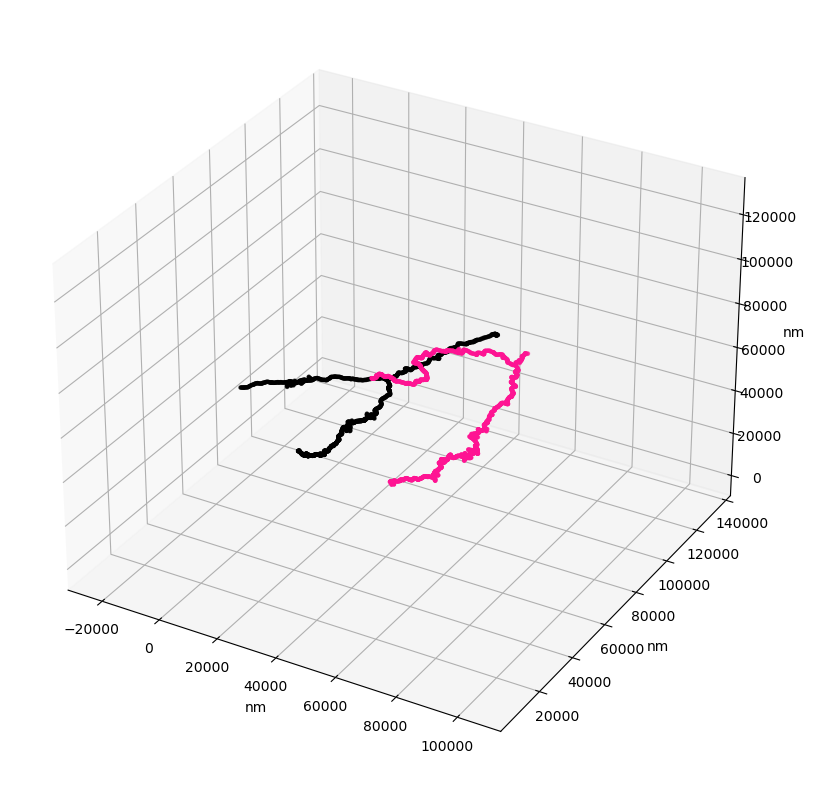

In [65]:
skel.viewer(color_by='component',draw_edges=False)
# skel_merged.viewer(color_by='component',draw_edges=False)

In [16]:
# for i, skel in enumerate(skel.components()):
#   with open('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/segments/VAST_to_ng/swc/' + str(skel.id) + '-' + str(i) + '.swc', 'wt') as f:
#     f.write(skel.to_swc())

In [220]:
skel.components()

[Skeleton(segid=1, vertices=(shape=9663, float32), edges=(shape=9662, uint32), radius=(9663, float32), space='voxel' transform=[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]])]

## export skeleton to swc

In [386]:
swc_outfile = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/swc')

In [387]:
cell_folder = 'sg2_393433572_mip2'

In [388]:
# Step 4: Write the SWC data to a file
with open(swc_outfile / f'{cell_folder}.swc', 'w') as swc_file:
    swc_file.write(skel.to_swc())

# branch length

In [10]:
def create_bins(boundaries):
    bins = []
    for i in range(len(boundaries) - 1):
        bins.append((boundaries[i], boundaries[i + 1]))
    return bins
    

In [11]:
vol = CloudVolume('precomputed://http://localhost:8000')

In [148]:
# HOW GET NUMBER OF SEGMENTS IN PRECOMPUTED TO LOOP THROUGH THEM?

In [12]:
seglist = [1,2,3,4,5,6]

mol_bounds = [1000, 3000, 5000, 7000, 9000, 12000,14000]
bins = create_bins(mol_bounds)

df_result= pd.DataFrame()
for seg in seglist:
    skel = vol.skeleton.get(seg)
    
    swc = skel.to_swc()
    
    df = npskel.skeleton_swc_to_df(swc)
    
    # change positions to 16nm segmentation scale(because that is the resolution in which y positions are marked)
    df['y'] = -(df['y']/16 - (16210)) # offset y position like do for spine density analysis
    df['x'] = df['x']/16
    df['z'] = df['z']/30
    vox_to_nm = 16 # to transform distance back into nm later
    
    d_total = []
    for b in bins:
        mask = (df['y']>b[0]) & (df['y']<b[1])
        G = npskel.skeleton_df_to_nx(df[mask], with_attributes=True, directed=True, with_distances=True, virtual_roots=True)
        distance=nx.get_edge_attributes(G,'distance')
        d_total.append(sum(filter(lambda x: x != float('inf'), np.asarray(list(distance.values()))))*vox_to_nm/1000)

    df_ = pd.DataFrame({
        'depth' : bins,
        'labels' : ['d0', 'd1', 'd2', 'd3', 'd4','d5'],
        'd_total' : d_total#,
        # 'seg' : seg        
    })
    df_['seg']=seg
    df_result = pd.concat([df_result,df_],ignore_index=True)

In [14]:
df_result.head()

,depth,labels,d_total,seg
0,"(1000, 3000)",d0,145.530303,1
1,"(3000, 5000)",d1,281.500061,1
2,"(5000, 7000)",d2,286.959523,1
3,"(7000, 9000)",d3,343.528475,1
4,"(9000, 12000)",d4,188.421729,1


<AxesSubplot:xlabel='labels', ylabel='d_total'>

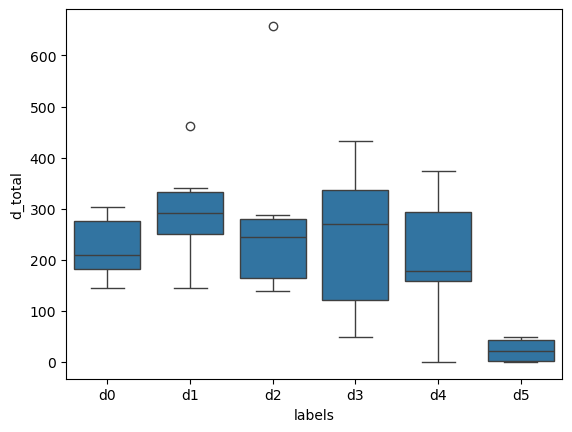

In [19]:
sns.boxplot(data = df_result,x = 'labels', y = 'd_total')

In [ ]:


# Define the y-range
y_min, y_max = 4, 10

# Function to calculate the path length for a subset of nodes
def calculate_path_length(G, nodes):
    subgraph = G.subgraph(nodes)
    total_length = 0
    for u, v in subgraph.edges():
        # Calculate edge length (Euclidean distance in 3D space)
        pos_u = subgraph.nodes[u]['pos']
        pos_v = subgraph.nodes[v]['pos']
        distance = sum((pos_u[i] - pos_v[i])**2 for i in range(3))**0.5
        total_length += distance
    return total_length

# Process each weakly connected component
for component in nx.weakly_connected_components(G):
    # Get the subset of nodes within the y-range
    nodes_in_range = [n for n in component if y_min <= G.nodes[n]['pos'][1] <= y_max]
    if nodes_in_range:
        path_length = calculate_path_length(G, nodes_in_range)
        print(f"Component {component} has path length {path_length:.2f} within the y-range.")

# Label nodes 

In [98]:
def find_closest_row(df, target_coords, multipliers=(128, 128, 120)):
    """
    Finds the row in the dataframe closest to the target coordinates after scaling.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'x', 'y', 'z', and 'rowId' columns.
        target_coords (tuple): Target coordinates (x, y, z) in original units.
        multipliers (tuple): Scaling factors for the coordinates (default is (16, 16, 30)).

    Returns:
        pd.Series: The row with the closest coordinates, including the rowId.
    """
    # Scale the target coordinates
    target_scaled = tuple(coord * multiplier for coord, multiplier in zip(target_coords, multipliers))
    
    # Calculate Euclidean distance to the target for each row
    df['distance'] = np.sqrt(
        (df['x'] - target_scaled[0])**2 +
        (df['y'] - target_scaled[1])**2 +
        (df['z'] - target_scaled[2])**2
    )
    
    # Find the closest row
    closest_row = df.loc[df['distance'].idxmin()]
    
    return closest_row #int(closest_row['rowId'])

def find_downstream_nodes_exclude_root(G, start_node, root_node):
    """
    Finds all downstream nodes from a given node, excluding those with paths containing the root node.

    Parameters:
        G (networkx.DiGraph): The directed graph.
        start_node (int): The node ID to start the search from.
        root_node (int): The root node to exclude from paths.

    Returns:
        list: A list of downstream node IDs that do not contain the root node in their paths.
    """
    if not G.has_node(start_node):
        raise ValueError(f"Start node {start_node} does not exist in the graph.")
    if not G.has_node(root_node):
        raise ValueError(f"Root node {root_node} does not exist in the graph.")
    
    # Perform depth-first search to find all reachable nodes
    all_downstream_nodes = list(nx.dfs_preorder_nodes(G, source=start_node))
    
    # Filter out nodes that have a path passing through the root node
    valid_nodes = []
    for node in all_downstream_nodes:
        if node == start_node:
            continue  # Skip the starting node itself
        paths_to_node = nx.all_simple_paths(G, source=start_node, target=node)
        # Check if any path includes the root node
        if not any(root_node in path for path in paths_to_node):
            valid_nodes.append(node)
    
    return valid_nodes

def find_downstream_nodes_all_paths_exclude_root(G, start_node, root_node, terminal_nodes):
    """
    Finds all nodes downstream of a given node in all paths, excluding those with paths containing the root node.

    Parameters:
        G (networkx.DiGraph): The directed graph.
        start_node (int): The node ID to start the search from.
        root_node (int): The root node to exclude from paths.

    Returns:
        list: A list of all downstream node IDs that do not contain the root node in their paths.
    """
    if not G.has_node(start_node):
        raise ValueError(f"Start node {start_node} does not exist in the graph.")
    if not G.has_node(root_node):
        raise ValueError(f"Root node {root_node} does not exist in the graph.")
    
    # List to store valid downstream nodes
    valid_downstream_nodes = set()

    valid_downstream_nodes = set()
    # Iterate through all nodes in the graph to find paths from start_node
    for node in terminal_nodes: #G.nodes:
        # Get all simple paths from start_node to node (if reachable)
        for path in nx.all_simple_paths(G, source=start_node, target=node):
            # If the path does not contain the root node, add the target node
            if root_node not in path:
                # valid_downstream_nodes.add(node)
                valid_downstream_nodes.update(path)
                break  # No need to check further paths to this node, since we found a valid one

    return list(valid_downstream_nodes)


def find_terminal_nodes(G):
    """
    Finds all terminal nodes in a directed graph (nodes with no outgoing edges).
    
    Parameters:
        G (networkx.DiGraph): The directed graph.
    
    Returns:
        list: A list of terminal node IDs (nodes with no outgoing edges).
    """
    return [node for node in G.nodes() if G.out_degree(node) == 0]

In [348]:
# all_paths = nx.all_simple_paths(G, source=start_node, target=terminal_nodes[10])

# nodes_in_paths = set()
# edges_in_paths = set()

# for path in all_paths:
#     print(path)
#     nodes_in_paths.update(path)
#     edges_in_paths.update(zip(path[:-1], path[1:]))

## neuprint swc to DataFrame

In [389]:
skelfile = '/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/swc/'
cell_folder = 'sg2_393433572_mip2' #sg2_387415866_crude_mip3.swc'

In [390]:
df = npskel.skeleton_swc_to_df(f'{skelfile}{cell_folder}.swc')

df.loc[:,'node_type']=0

In [391]:
npskel.reorient_skeleton(df,use_max_radius=True)

In [392]:
df.sort_values('radius')

,rowId,x,y,z,radius,link,node_type
7347,7348,301792.0,339040.0,45870.0,60.000000,7347,0
1245,1246,308320.0,331232.0,41070.0,60.000000,1245,0
5312,5313,318880.0,304032.0,60990.0,60.000000,5312,0
5553,5554,316640.0,293600.0,50850.0,60.000000,5553,0
5313,5314,318816.0,303968.0,61050.0,60.000000,5313,0
...,...,...,...,...,...,...,...
5231,5232,318624.0,308896.0,61290.0,2477.033691,5233,0
1544,1545,318432.0,308896.0,61590.0,2481.238281,1544,0
5232,5233,318688.0,308832.0,61350.0,2482.063721,5234,0
5235,5236,318880.0,308704.0,61230.0,2487.758789,5235,0


## df to iGraph to find nodes in paths without root

In [393]:
G = npskel.skeleton_df_to_nx(df, with_attributes=True, directed=True, with_distances=True, virtual_roots=False)
G = G.reverse()

In [394]:
terminal_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]

In [395]:
df[df['link'].isin([-1])]

,rowId,x,y,z,radius,link,node_type
5233,5234,318752.0,308768.0,61350.0,2488.607666,-1,0


In [396]:
df.loc[df['link'].isin([-1]),'node_type'] = 1

In [410]:
# Example usage
# Assuming your DataFrame is named `df`
target_coords = (2469, 2426, 532)
'''
axon: mg2 (1683, 2026, 231) sg2(1517, 2152, 562) 
basal dendrite: mg2(1677, 2114, 298) sg2(1491, 2154, 520)
apical dendrite: mg2(1703, 1972, 280) sg2(1473, 2070, 543) 
'''
closest_row = find_closest_row(df, target_coords, multipliers = (128,128,120))
print(f"Closest rowId: {int(closest_row['rowId'])}")
print(closest_row)

Closest rowId: 5092
rowId          5092.000000
x            316128.000000
y            310560.000000
z             63930.000000
radius           60.000000
link           5091.000000
node_type         0.000000
distance        135.425256
Name: 5091, dtype: float64


In [411]:
# Example usage
start_node = int(closest_row['rowId'])  # Replace with your starting node
root_node = df[df['link'].isin([-1])]['rowId'].values[0]#7932# 1  # Replace with the root node ID
valid_downstream_nodes = find_downstream_nodes_all_paths_exclude_root(G, start_node, root_node,terminal_nodes)

# print(f"Valid downstream nodes from {start_node} (excluding paths through root {root_node}): {valid_downstream_nodes}")

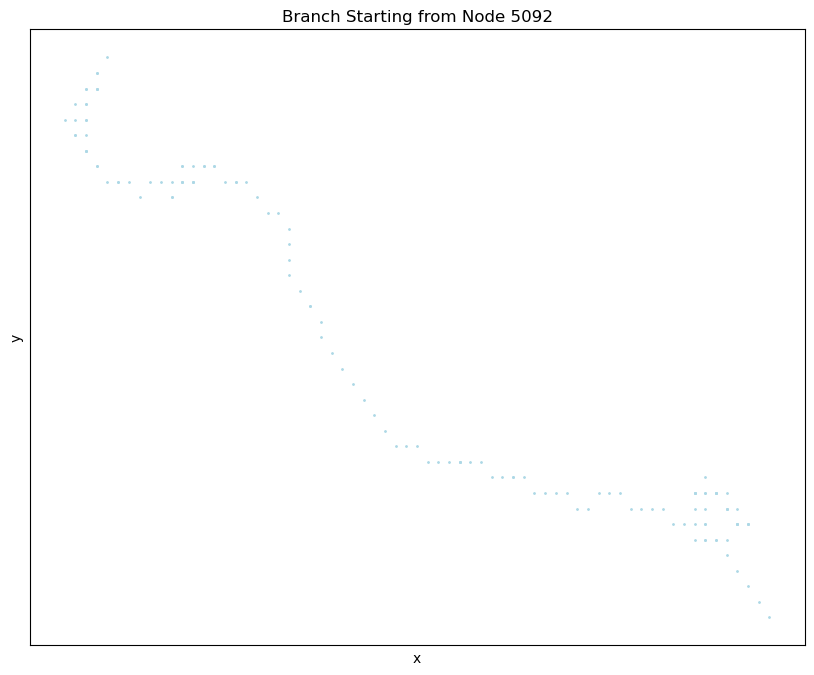

In [412]:

# branch_edges = list(nx.edge_dfs(G.subgraph(valid_downstream_nodes), source=start_node))

# Extract the subgraph for the branch
branch_subgraph = G.subgraph(valid_downstream_nodes)

pos = {node: (branch_subgraph.nodes[node]['x'], branch_subgraph.nodes[node]['y']) for node in valid_downstream_nodes} #G.nodes}

# Draw the branch subgraph
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(branch_subgraph, pos, node_color='lightblue', node_size=1) #, edge_color='gray', with_labels=False
plt.title(f"Branch Starting from Node {start_node}")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [413]:
'''
1: soma
2: axon
3: basal dendrite
4: apical dendrite
'''

df.loc[df['rowId'].isin(valid_downstream_nodes),'node_type'] = 3

In [414]:
df = df.sort_values('link')

## back to cloudvolume skel format

In [415]:
df.head()

,rowId,x,y,z,radius,link,node_type,distance
5233,5234,318752.0,308768.0,61350.0,2488.607666,-1,1,4086.086147
7279,7280,300704.0,334688.0,46770.0,155.177322,1,3,33317.233979
0,1,300704.0,334624.0,46830.0,155.177322,2,3,33240.109747
1,2,300768.0,334560.0,46890.0,128.000000,3,3,33133.505942
2,3,300768.0,334496.0,46950.0,143.108353,4,3,33056.418681


### cv-derived functions to reorder after root change

In [165]:
from collections import defaultdict

# def to_swc(self, contributors=""):

def render_row(row):
  return "{n} {T} {x:0.6f} {y:0.6f} {z:0.6f} {R:0.6f} {P}".format(
    n=row[0],
    T=row[1],
    x=row[2],
    y=row[3],
    z=row[4],
    R=row[5],
    P=row[6],
  )

# skels = self.components()
def renumber(rows):
  mapping = { -1: -1 }
  N = 1
  for row in rows:
    node = row[0]
    if node in mapping:
      row[0] = mapping[node]
      continue
    else:
      row[0] = N
      mapping[node] = N
      N += 1

  for row in rows:
    row[-1] = mapping[row[-1]]

  return rows

### initialize swc string

In [416]:
"""
Prototype SWC file generator. 
The SWC format was first defined in 

R.C Cannona, D.A Turner, G.K Pyapali, H.V Wheal. 
"An on-line archive of reconstructed hippocampal neurons".
Journal of Neuroscience Methods
Volume 84, Issues 1-2, 1 October 1998, Pages 49-54
doi: 10.1016/S0165-0270(98)00091-0
This website is also helpful for understanding the format:
https://web.archive.org/web/20180423163403/http://research.mssm.edu/cnic/swc.html
Returns: swc as a string
"""
from cloudvolume import __version__
# sx, sy, sz = np.diag(self.transform)[:3]
swc_header = f"""# ORIGINAL_SOURCE CloudVolume modified scripts 11.1.1
# CREATURE 
# REGION
# FIELD/LAYER
# TYPE
# CONTRIBUTOR kperks
# REFERENCE
# RAW 
# EXTRAS 
# SOMA_AREA
# SHINKAGE_CORRECTION 
# SCALE don't know how to get from dataframe yet 
"""
# VERSION_DATE {datetime.datetime.utcnow().isoformat()}
#SCALE {sx:.6f} {sy:.6f} {sz:.6f}

skels = skel.components()
swc = swc_header + "\n"
offset = 0
# for skel in skels:
#   swc += generate_swc(skel, offset) + "\n"

### extract rows to list from DataFrame

In [417]:
all_rows = []
# Iterate over each row
for index, r in df.iterrows():
    # Create list for the current row
    row_list =[int(r.rowId), int(r.node_type), r.x, r.y, r.z, r.radius, int(r.link)]
    # append the list to the final list
    all_rows.append(row_list)

### renumber rows needed due to root node change

In [418]:
all_rows = renumber(all_rows)

In [419]:
all_rows[0:4]

[[1, 1, 318752.0, 308768.0, 61350.0, 2488.607666015625, -1],
 [2, 3, 300704.0, 334688.0, 46770.0, 155.1773223876953, 3],
 [3, 3, 300704.0, 334624.0, 46830.0, 155.1773223876953, 4],
 [4, 3, 300768.0, 334560.0, 46890.0, 128.0, 5]]

### add rows to swc string

In [420]:
swc += "\n".join((
  render_row(row)
  for row in all_rows
))

# return swc

### CloudVolume Skeleton from swc string

In [421]:
# skel = Skeleton.from_swc(skelfile_labeled)

lines = swc.split("\n")

while len(lines) and (lines[0] == '' or re.match(r'[#\s]', lines[0][0])):
  l = lines.pop(0)

if len(lines) == 0:
  # return Skeleton()
    skel_fromswc = Skeleton()

vertices = []
edges = []
radii = []
vertex_types = []

label_index = {}

N = 0

for line in lines:
  if line.replace(r"\s", '') == '':
    continue
  (vid, vtype, x, y, z, radius, parent_id) = line.split(" ")
  
  coord = tuple([ float(_) for _ in (x,y,z) ])
  vid = int(vid)
  parent_id = int(parent_id)

  label_index[vid] = N

  if parent_id >= 0:
    if vid < parent_id:
      edge = [vid, parent_id]
    else:
      edge = [parent_id, vid]

    edges.append(edge)

  vertices.append(coord)
  vertex_types.append(int(vtype))

  try:
    radius = float(radius)
  except ValueError:
    radius = -1 # e.g. radius = NA or N/A

  radii.append(radius)

  N += 1

for edge in edges:
  edge[0] = label_index[edge[0]]
  edge[1] = label_index[edge[1]]

In [422]:
skel_fromswc = Skeleton(vertices, edges, radii, vertex_types)

In [423]:
skel_fromswc

Skeleton(segid=None, vertices=(shape=7348, float32), edges=(shape=7347, uint32), radius=(7348, float32), vertex_types=(7348, uint8), space='voxel' transform=[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]])

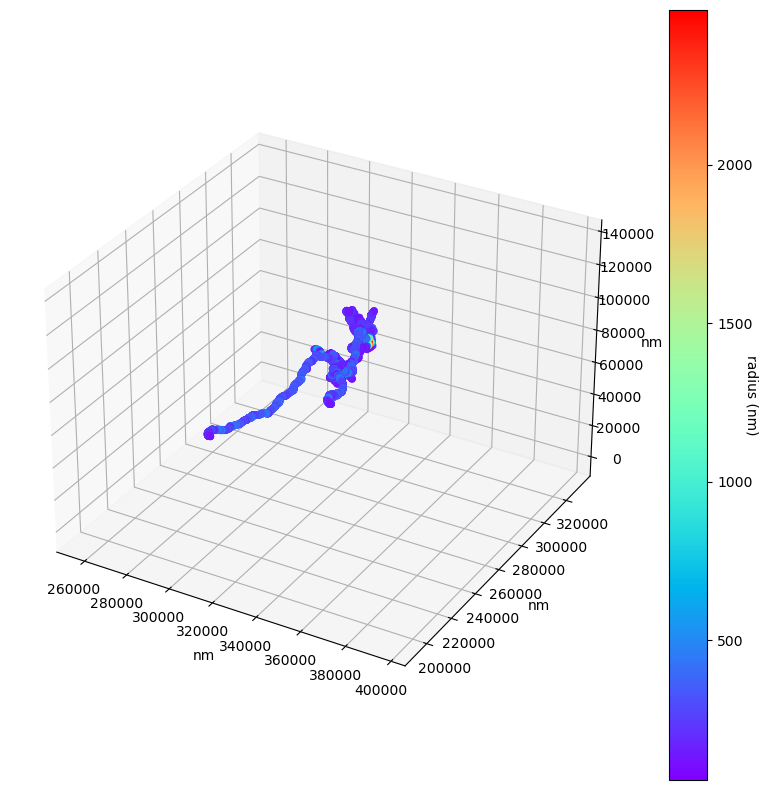

In [424]:
skel_fromswc.viewer()

### export swc from Skeleton

In [425]:
swc_outfile = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/VAST_to_ng/swc')

In [426]:
cell_folder = 'sg2_393433572_mip2_maincomponent_labeled'

In [427]:
# Step 4: Write the SWC data to a file
with open(swc_outfile / f'{cell_folder}.swc', 'w') as swc_file:
    swc_file.write(skel_fromswc.to_swc())

# location in VAST from local

In [123]:
local_loc = (1496, 2175, 524) #x,y,z
local_offset = (1232, 520, 160)
local_res = (128,128,120)
VAST_res = (16,16,30)


VAST_loc = [(l)*r/v for l,o,r,v in zip(local_loc,local_offset,local_res,VAST_res)]

VAST_loc

[11968.0, 17400.0, 2096.0]

In [ ]:
1484, 2080, 641
1558, 2174, 664
1692, 2227, 536
1573, 2194, 465
1598, 2212, 396
1667, 2249, 389
1483, 2207, 477
1587, 2209, 359

# OBJ from Local Mesh CloudVolume retrieve http

In [2]:
import trimesh

In [34]:
vol = CloudVolume('precomputed://http://localhost:8000')

In [35]:
mesh= vol.mesh.get(1)

Decoding Mesh Buffer: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 5138.82it/s]


In [36]:
reduction_ratio = 0.2

scale_factor = 100000
yaxis_replace_scale = 32768*16/scale_factor
# zaxis_replace_scale = 3534*30/scale_factor
refpt = [0,0,0]

In [37]:
vertices = mesh.vertices
vertices = vertices/scale_factor
vertices = [[v[0]-refpt[0],v[1]-refpt[1],v[2]-refpt[2]] for i,v in enumerate(vertices)]
vertices = [[v[0],yaxis_replace_scale-v[1],v[2]] for v in vertices]
faces = mesh.faces
trimesh_mesh = trimesh.Trimesh(vertices=vertices, faces=faces,process=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.21it/s]


In [8]:
# downsample the fused mesh before joining to the fused_mesh and exporting as a .obj for blender
simplified_mesh = trimesh_mesh.simplify_quadric_decimation(face_count=len(trimesh_mesh.vertices) * reduction_ratio)


In [38]:
trimesh_mesh.export(Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/ms/figures/blender/Fig3/obj') / 'pf_369297193_skeleton_4nm.obj');